In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import tensorflow.keras.backend as be


In [212]:
df = pd.read_csv("boston_corrected.csv")
train_set, test_set = train_test_split(df, test_size=0.2, random_state=26)


In [446]:
input_vars = ["LON", "LAT"]
output_vars = ['DIS', "TRACT", "RM","INDUS",'NOX', 'LSTAT',"ZN", 'PTRATIO', 'CMEDV']

INPUT_SCALER = StandardScaler()
INPUT_SCALER.fit(df[input_vars].values)

input_scalers = {"LAT": INPUT_SCALER}
current_vars =["LON", "LAT"] 
for output in output_vars:
    current_vars.append(output)
    INPUT_SCALER_n = StandardScaler()
    INPUT_SCALER_n.fit(df[current_vars].values)
    

    input_scalers[output] = INPUT_SCALER_n
    print("Input scaler: ", len(input_scalers), " is ", current_vars, " with key: ",output )


INPUT = INPUT_SCALER.transform(train_set[input_vars])
INPUT_TEST = INPUT_SCALER.transform(test_set[input_vars])

Input scaler:  2  is  ['LON', 'LAT', 'DIS']  with key:  DIS
Input scaler:  3  is  ['LON', 'LAT', 'DIS', 'TRACT']  with key:  TRACT
Input scaler:  4  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM']  with key:  RM
Input scaler:  5  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM', 'INDUS']  with key:  INDUS
Input scaler:  6  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM', 'INDUS', 'NOX']  with key:  NOX
Input scaler:  7  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM', 'INDUS', 'NOX', 'LSTAT']  with key:  LSTAT
Input scaler:  8  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM', 'INDUS', 'NOX', 'LSTAT', 'ZN']  with key:  ZN
Input scaler:  9  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM', 'INDUS', 'NOX', 'LSTAT', 'ZN', 'PTRATIO']  with key:  PTRATIO
Input scaler:  10  is  ['LON', 'LAT', 'DIS', 'TRACT', 'RM', 'INDUS', 'NOX', 'LSTAT', 'ZN', 'PTRATIO', 'CMEDV']  with key:  CMEDV


In [447]:
def QuadLoss():
    pass
def CreateModel(inSize):
    model = keras.models.Sequential()

    #model.add(keras.Input(shape=inSize))
    model.add(keras.layers.Dense(inSize))

    model.add(keras.layers.Dense(40, activation='relu'))

    model.add(keras.layers.Dense(40, activation='sigmoid'))
    #model.add(keras.layers.Dense(40, activation='sigmoid'))
    model.add(keras.layers.Dense(40, activation='relu'))
    #model.add(keras.layers.Dense(40, activation='selu'))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics=["mean_squared_error"])

    return model

def TrainModel(model, input_vars, output_var, epochs, batch_size):
    
    #Scale and create our output data
    #OUT_SCALER = StandardScaler()
    #OUT_SCALER.fit(df[output_var])
    
    most_recent = input_vars[len(input_vars)-1]
    
    print(most_recent)
    
    OUTPUT = train_set[output_var].values#OUT_SCALER.transform(train_set[output_var])
    
    input_scaler = input_scalers[most_recent]
    
    ThisInput = input_scaler.transform(train_set[input_vars].values)
    
    model.fit(ThisInput, OUTPUT, epochs=epochs, batch_size=batch_size, verbose=0)
    
    InputTest = input_scaler.transform(test_set[input_vars])
    model_predict = model.predict(InputTest)
    
    #model_predict = OUT_SCALER.inverse_transform(model_predict_scaled)
    
    return model_predict

In [450]:
def TrainAndTest(input_vars, output_var):
    model = CreateModel(len(input_vars))
    predict_vals = TrainModel(model,input_vars, output_var, 100, 10)
    plt.title(output_var)
    plt.plot(predict_vals, label="pred")
    plt.plot(test_set[output_var].values, label="true")
    plt.legend()
    
    plt.show()
    return model
    

LAT


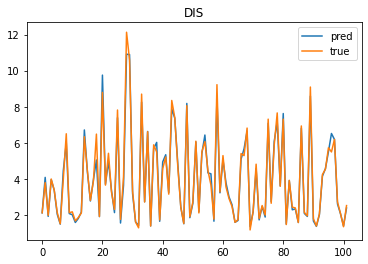

Model  0  has  2 vars:  ['LON', 'LAT']
DIS


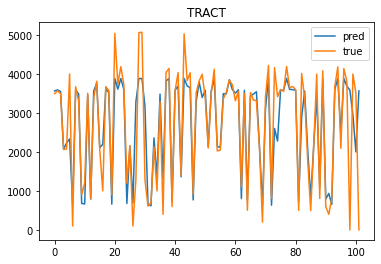

Model  1  has  3 vars:  ['LON', 'LAT', 'DIS']
TRACT


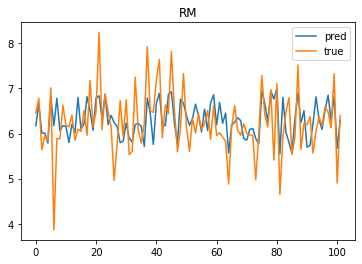

Model  2  has  4 vars:  ['LON', 'LAT', 'DIS', 'TRACT']
RM


In [ ]:
this_input_vars =  ["LON", "LAT"]

all_models = []


for i, var in enumerate(output_vars):
    all_models.append(TrainAndTest(this_input_vars, var))
    
    print("Model ", i , " has ", len(this_input_vars), "vars: ", this_input_vars)
    
    this_input_vars.append(var)

In [361]:
print(all_models[1])

In [386]:
map = mpimg.imread('map.png')
minLon = min(df["LON"].values)
maxLon = max(df["LON"].values)
minLat = min(df["LAT"].values)
maxLat = max(df["LAT"].values)


def latLonToXY(lat, lon):
    
    lonScale = 2300
    dLon = 250
    latScale = 3200
    dLat = 280
    
    return (lon-minLon) * lonScale + dLon, map.shape[1] - ((lat-minLat) * latScale + dLat)


def XYToLat(x,y):
    #x = (lon-minLon) * lonScale + dLon
    #lon = (x - dLon)/lonScale + minLon
    #y = height - ((lon-minLon) * lonScale + dLon)
    #lon = (x - dLon)/lonScale + minLon
    lonScale = 2300
    dLon = 250
    latScale = 3200
    dLat = 280
    
    lon = (x - dLon)/lonScale + minLon
    lat = (map.shape[1]-y - dLat)/latScale + minLat
    return lon, lat

def CreateModelMask(model, scaler, gridSize=100, other_masks=None, maskCut=0):
    
    height = int(map.shape[0] / gridSize)
    width = int(map.shape[1] / gridSize)
    print(width * height)
   # result = np.zeros((height, width, 4))

    extra_vars_len = maskCut

    result = np.zeros((height, width))
    LONLAT = np.zeros((height*width, 2+extra_vars_len))
    
    
    j = 0
    for x in range(width):
        for y in range(height):
            
            vals = np.zeros(2 + extra_vars_len)
            lon,lat = XYToLat(x*gridSize,y*gridSize)
            vals[0] = lon
            vals[1] = lat
            
            for i in range(extra_vars_len):
                vals[i+2] = other_masks[y,x, i]
                #vals = 0,0,0
            
            LONLAT[j,:] =  vals
          #  print(x,y, " and", LONLAT[i])
            #print(j,LONLAT[j,:])
            j+=1
            #lon, lat = XYToLat(x,y)
            #val = model.predict(INPUT_SCALER.transform([[lon, lat]]))
            #print(val[0,0])
            #if(val > 5000):
            #result[y,x] = val
    
    for i,layer in enumerate(model.layers):
        print(layer.input_shape)

    
    #print(LONLAT)
    scaled = scaler.transform(LONLAT)
    print(LONLAT.shape)
    predict =  model.predict(scaled)
    #print(predict)
    i=0
    for x in range(width):
        for y in range(height):
            result[y,x] = predict[i]
            i+=1
            #print(result[y,x])
    #print(min(predict))
    #print(max(predict))
    return result
    


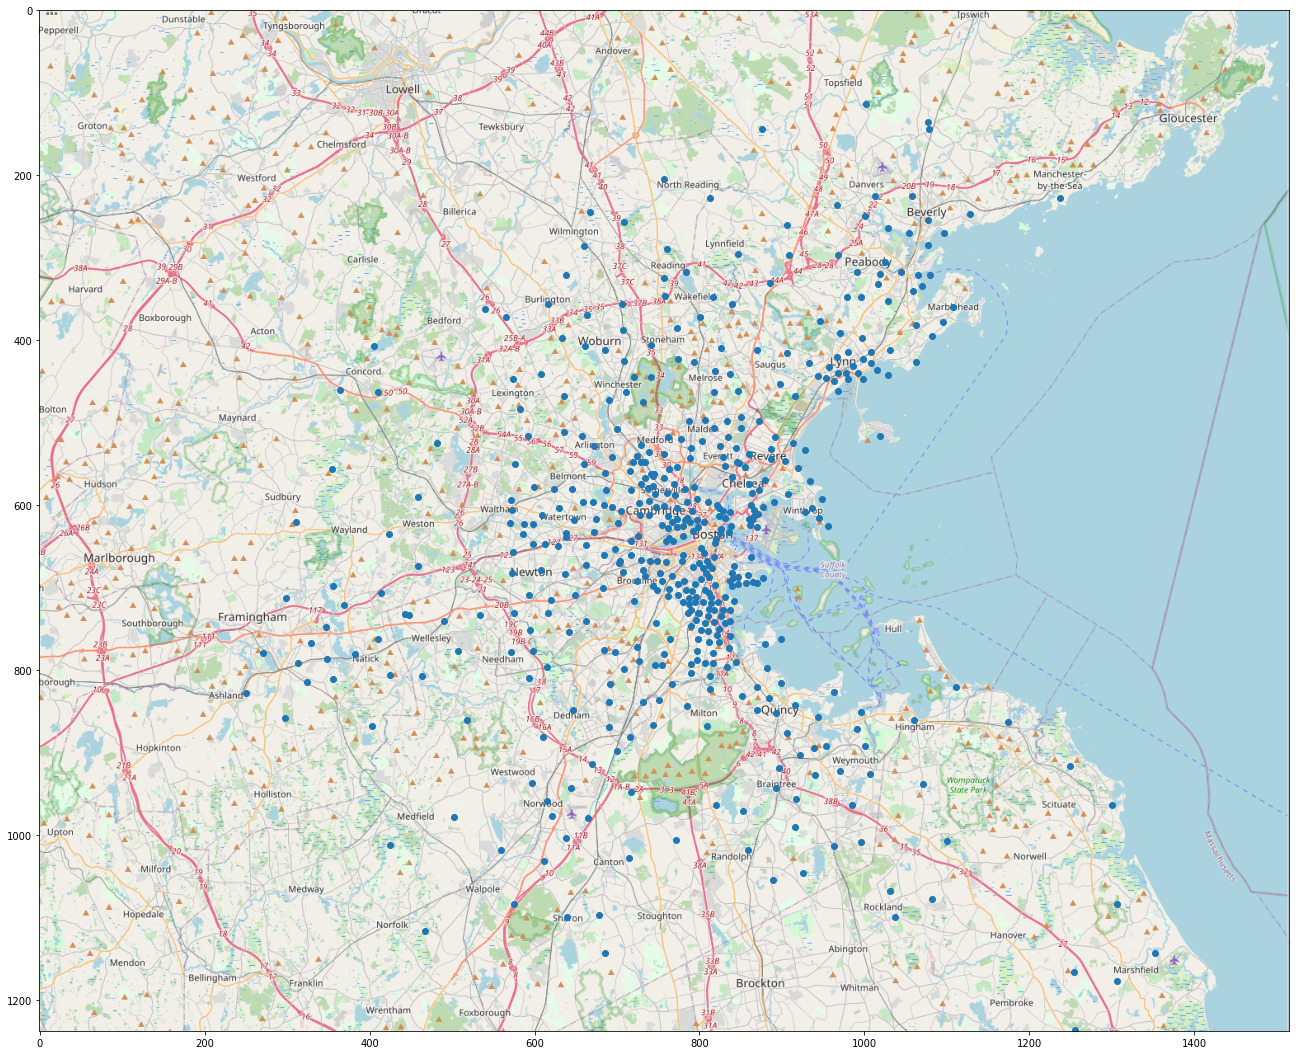

In [387]:
fig = plt.figure(figsize=(11.20 * 2, 15.11 * 2))
plt.imshow(map)
select = df.copy()#df.loc[(df["TOWN"]=="Chelsea") | (df["TOWN"]=="Quincy") | (df["TOWN"]=="Marblehead")]

x,y = latLonToXY(select["LAT"].values, select["LON"].values)
plt.scatter(x,y)

#modelMask = CreateModelMask(model)


In [438]:


def CreateAllMasks(models, gridSize=20):
    
    height = int(map.shape[0] / gridSize)
    width = int(map.shape[1] / gridSize)
    
    each_mask = np.zeros((height, width, len(output_vars)))
    
    this_output = ["LAT"] + output_vars
    #this_outputappend(output_vars)
    
    print(this_output)
    #We iterate each variable, our model 'i' will predict
    for i,var in enumerate(this_output):
        if(i == len(this_output)-1):
            break
        print(var,i)

        #we get the model that tries to find the current var
        model = models[i]
        #get the current scaler
        scaler = input_scalers[var]
        print(model, ",", i )
        cur_mask = CreateModelMask(models[i], scaler, gridSize, each_mask, i)
        each_mask[:,:,i] = cur_mask
    return each_mask
end_mask = CreateAllMasks(all_models)


['LAT', 'DIS', 'NOX', 'LSTAT', 'PTRATIO', 'CMEDV']
LAT 0
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B340B48BE0> , 0
4575
(None, 2)
(None, 2)
(None, 40)
(None, 40)
(None, 40)
(4575, 2)
DIS 1
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B33F893910> , 1
4575
(None, 3)
(None, 3)
(None, 40)
(None, 40)
(None, 40)
(4575, 3)
NOX 2
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B35AD7B2B0> , 2
4575
(None, 4)
(None, 4)
(None, 40)
(None, 40)
(None, 40)
(4575, 4)
LSTAT 3
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B3759A4100> , 3
4575
(None, 5)
(None, 5)
(None, 40)
(None, 40)
(None, 40)
(4575, 5)
PTRATIO 4
<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B33F79B3D0> , 4
4575
(None, 6)
(None, 6)
(None, 40)
(None, 40)
(None, 40)
(4575, 6)


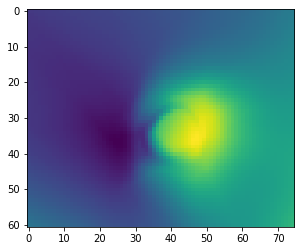

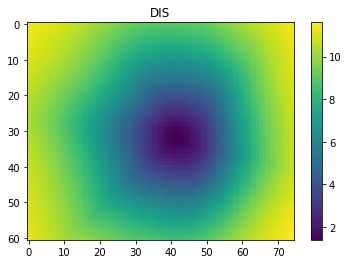

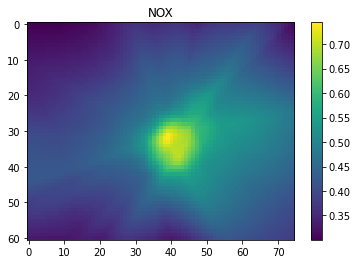

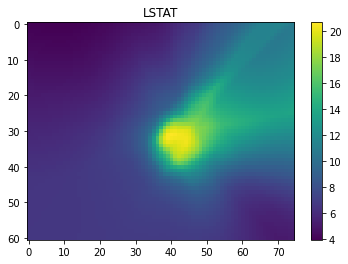

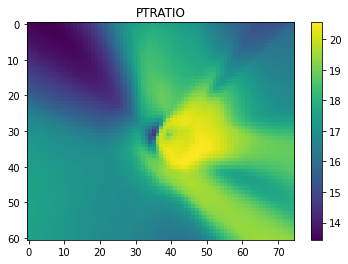

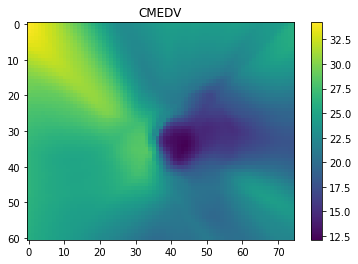

In [442]:

N = len(output_vars)
subX = int(np.sqrt(N))

#fig = plt.figure(figsize=(12,9))

for i in range(N):
    #ax = fig.add_subplots(N,N,i+1)
    plt.title(output_vars[i])
    plt.imshow(end_mask[:,:,i])
    plt.colorbar()
    plt.show()